In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize

Text(0, 0.5, 'Force (N)')

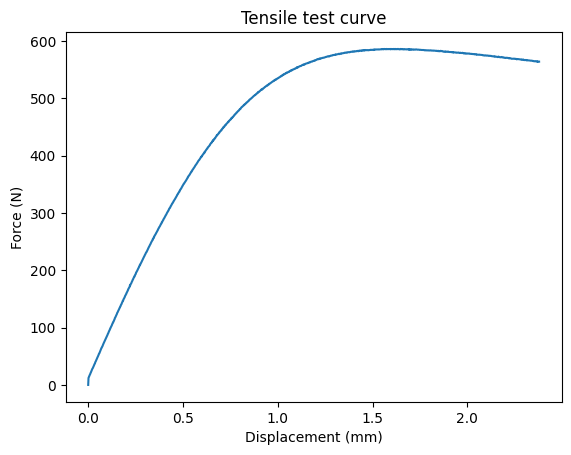

In [2]:
# Read from Tensile_test.xlsx
df = pd.read_excel('Tensile_test.xlsx')
forceTensile = df['Force (N)']
displacementTensile = df['Extension (mm)']

# Plot stress strain curve
plt.title('Tensile test curve')
plt.plot(displacementTensile, forceTensile)
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')

Text(0, 0.5, 'Stress, MPa')

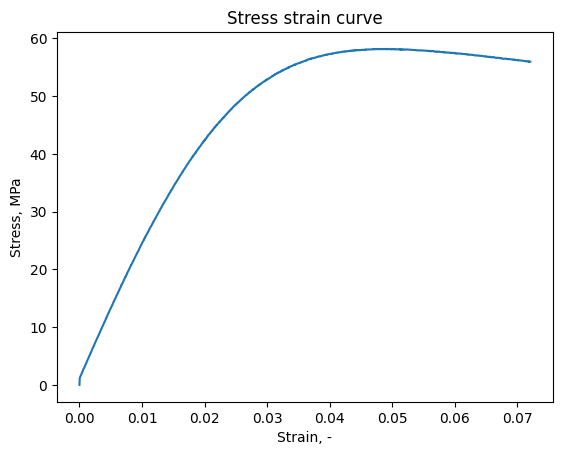

In [3]:
# Cross section properties
width = 6 # mm
thickness = 1.68 # mm
# Original length
L0 = 33 # mm
area = width * thickness # mm^2
stress = forceTensile / area # N/mm^2 = MPa
strain = displacementTensile / L0 # mm/mm = dimensionless

# Plot stress strain curve
plt.title('Stress strain curve')
plt.plot(strain, stress)
plt.xlabel('Strain, -')
plt.ylabel('Stress, MPa')

In [4]:
# Fit linear regression to the first 300 data points of stress strain curve
numberOfPoints = 300
strain = np.array(strain)
stress = np.array(stress)
strain = strain.reshape(-1, 1)
stress = stress.reshape(-1, 1)
reg = LinearRegression()
reg.fit(strain[0:numberOfPoints], stress[0:numberOfPoints])
# Slope
print(f"Youngs modulus: {round(reg.coef_[0][0])} MPA")

Youngs modulus: 2289 MPA


Text(0, 0.5, 'Stress, MPa')

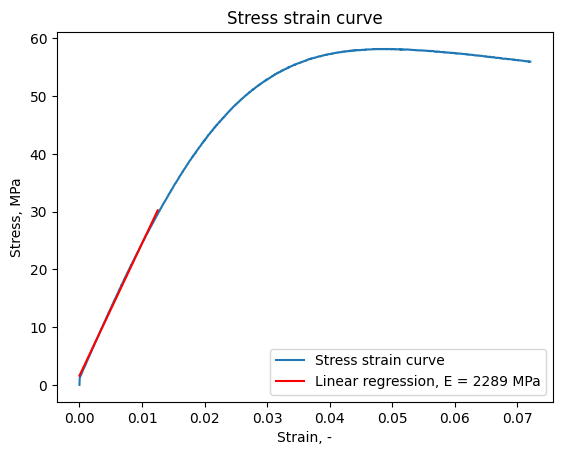

In [5]:
# Plot linear regression with stress strain curve
# Plot stress strain curve
plt.title('Stress strain curve')
plt.plot(strain, stress)
plt.plot(strain[0:numberOfPoints], reg.predict(strain)[0:numberOfPoints], color='red')
plt.legend(['Stress strain curve', f'Linear regression, E = {round(reg.coef_[0][0])} MPa'])
plt.xlabel('Strain, -')
plt.ylabel('Stress, MPa')


Text(0, 0.5, 'Force (N)')

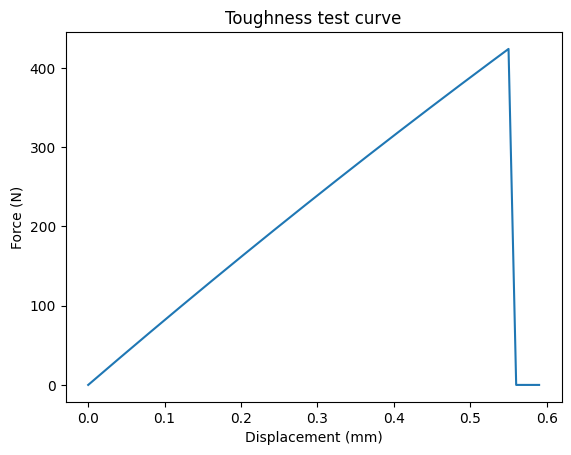

In [6]:
# Read from Toughness_test.xlsx

df = pd.read_excel('Toughness_test.xlsx')
forceToughness = df['Force (N)']
displacementToughness = df['Extension (mm)']

# Plot toughness curve
plt.title('Toughness test curve')
plt.plot(displacementToughness, forceToughness)
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')

In [7]:
# Maximum force at fracture moment
P = max(forceToughness)
print(f"Critical force: {round(P)} N")

Critical force: 424 N


In [8]:
# Compact tension specimen
a = 0.030 # m
W = 0.06 # m
# We have B = Bn
B = 0.015 # m
Bn = 0.015 # m

def f(a, W):
    aW = a / W
    nominator = (2 + aW) * (0.886 + 4.64 * aW - 13.32 * aW**2 + 14.72 * aW**3 - 5.6 * aW**4)
    denominator = (1 - aW) ** (3/2)
    return nominator/denominator 

# Return Kic of unit Pa√(m)
def Kic_equation(P, B, Bn, a, W):
    return P/(np.sqrt(B * Bn) * np.sqrt(W)) * f(a, W) 

# The fracture toughness Kic of the material is:
Kic = Kic_equation(P, B, Bn, a, W)
print(f"Fracture toughness: {round(Kic) * 1e-6} MPa√(m)")

Fracture toughness: 1.11485 MPa√(m)


In [12]:
# Linear regression between stress intensity factor KI and applied force P
P = np.array([1, 250, 500, 750, 1000])
KI = np.array([5322.84,1.33071E+06, 2.66142E+06,3.99213E+06,5.32284E+06])
# fit linear regression
P = P.reshape(-1, 1)
KI = KI.reshape(-1, 1)
reg = LinearRegression()
reg.fit(KI, P)
# Slope
print(f"Slope of linear regression between P and KI: {reg.coef_[0][0]}")

Slope of linear regression between P and KI: 0.000187869633503919


In [35]:
# Predict Pmax at stress intensity factor KI = KIc = 1114850 Pa√(m)
KIc = 1114850
Pmax = reg.predict([[KIc]]).item()
print(f"Maximum force at fracture moment: Pmax = {round(Pmax, 2)} N")

Maximum force at fracture moment: Pmax = 209.45 N


In [36]:
# Arc-shape tension specimen
a = 0.01 # m
B = 0.01 # m
r1 = 0.03 # m
r2 = 0.06 # m
W = 0.03 # m
X = 0.015 # m

KIc = 1114850 # Pa√(m)
def f(a, W):
    aW = a / W
    firstTerm = np.sqrt(aW)/(1-aW)**(3/2)
    secondTerm = 3.74 - 6.30 * aW + 6.32 * aW**2 - 2.43 * aW **3
    return firstTerm * secondTerm

# Return KI of unit Pa√(m)
def KQ_equation(P, B, X, r1, r2, a, W):
    firstTerm = P /(B * np.sqrt(W))
    secondTerm = 3 * (X/W) + 1.9 + 1.1 * (a/W)
    thirdTerm = 1 + 0.25 * (1 - a/W) ** 2 * (1 - r1/r2)
    fourthTerm = f(a, W)
    return firstTerm * secondTerm * thirdTerm * fourthTerm

# Return KI of unit Pa√(m), no other params exept P
def KQ_equation_P(P):
    firstTerm = P /(B * np.sqrt(W))
    secondTerm = 3 * (X/W) + 1.9 + 1.1 * (a/W)
    thirdTerm = 1 + 0.25 * (1 - a/W) ** 2 * (1 - r1/r2)
    fourthTerm = f(a, W)
    return firstTerm * secondTerm * thirdTerm * fourthTerm - KIc


In [38]:
# KQ at Pmax = 209.45
KQ = KQ_equation(Pmax, B, X, r1, r2, a, W)
print(f"Stress intensity factor KQ at Pmax: {round(KQ)} Pa√(m)")

Stress intensity factor KQ at Pmax: 1148519 Pa√(m)


In [43]:
sol = optimize.root_scalar(KQ_equation_P, bracket = [0,1000],  method='brentq')
print(F"Pmax given KIc is {round(sol.root,2)} N")

Pmax given KIc is 203.31 N
